In [ ]:
!pip install --upgrade tensorflow==2.11.0

In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q tf-models-official==2.11.0

In [ ]:
!pip install --upgrade "tensorflow-text==2.11.*"

In [ ]:
!pip install pymorphy2

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer 


from keras.utils import np_utils

import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    Conv1D, 
    Flatten, 
    GlobalMaxPooling1D, 
    Embedding, 
    Bidirectional, 
    Input,
    LSTM,
    BatchNormalization)
from tensorflow.keras.optimizers import (
    Adam,
    RMSprop, 
    SGD
)
from tensorflow.keras.preprocessing import (
    sequence, 
    text
)


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import offsetbox
%matplotlib inline
import seaborn as sns

import os
from tqdm import tqdm
from time import time
from string import punctuation
import random

from google.colab import files

from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler,
    normalize
)
from sklearn.metrics import (
    confusion_matrix, 
    classification_report
)

In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('stopwords')

In [ ]:
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mikhailklemin/kinopoisks-movies-reviews

In [ ]:
!unzip /content/kinopoisks-movies-reviews.zip

In [ ]:
bert_preprocess = 'https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang_preprocess/1'
bert_model = 'https://tfhub.dev/jeongukjae/smaller_LaBSE_15lang/1'

In [ ]:
punct = punctuation + "`ˈː—«» ́ …° ͡ "

In [ ]:
morph = MorphAnalyzer()

In [ ]:
pos_dir = '/content/dataset/pos'
neu_dir = '/content/dataset/neu'
neg_dir = '/content/dataset/neg'

In [ ]:
TOP_K = 2000
MAX_SEQUENCE_LENGTH = 250

Выбираем по 2000 отзывов с каждым лэйблом и сразу лемматизируем

In [ ]:
X = []
Y = []

In [ ]:
stop_words = set(stopwords.words('russian'))

In [ ]:
for dir in [neg_dir, neu_dir, pos_dir]:
    sample = random.sample(os.listdir(dir), 2000)
    for rev in tqdm(sample):
        rev_path = os.path.join(dir, rev)
        with open(rev_path, "r", encoding="utf-8") as r_src:
            lemmatized = []
            no_stopwords = []
            for token in word_tokenize(r_src.read()):
                token_stripped = token.strip(punct) 
                if token_stripped:
                    lemma = morph.parse(token_stripped)[0].normal_form
                    if lemma not in stop_words:
                      lemmatized.append(lemma)
        X.append(' '.join(lemmatized))
        Y.append(dir.split('/')[-1])

100%|██████████| 2000/2000 [03:18<00:00, 10.09it/s]


Преобразуем лейблы

In [ ]:
Y_int = LabelEncoder().fit_transform(Y)

In [ ]:
Y = np_utils.to_categorical(Y_int, 3)

In [ ]:
str_labels = sorted(os.listdir('/content/dataset/'))

In [ ]:
for i in random.sample(range(6000), 3):
    print('Review:')
    print(X[i])
    print('Vector label:', Y[i])
    num_label = np.argmax(Y[i])
    print('Numeric label:', num_label)
    print('String label:', str_labels[num_label])
    print('\n')

Review:
оливер стоун никто знать творческий кризис несколько десятилетие назад фильм стабильно получать номинация оскар золотой глобус c недавний пора работа стать интересоваться комитет золотой малина изрядно портить репутация отдельно взять личность фильм целое грандиозный провал александр дать повод усомниться высокий квалификация режиссёр менее стоун стать принимать необдуманный решение наподобие уход профессия успокоить явно занервничать фанат слава бог отложить выход пенсия продолжить искать вдохновение самый разносторонний жанр привести 2012 год высоковольтный криминальный триллер особо опасный который возвратить стоун оптимальный форма зато дать возможность весь желать оценить новомодный комбинация маэстро занудный сиквел уолл-стрита стоун решить попробовать что-то новый точнее забытый старое особо опасный пропитать безумный энергетика который позволить прирождённый убийца 1994 год взять специальный приз жюри венецианский кинофестиваль украинский версия беспорядок который обесп

Токенизация текстов

In [ ]:
tokenizer = text.Tokenizer(num_words=TOP_K)

In [ ]:
tokenizer.fit_on_texts(X)

In [ ]:
vec_X = tokenizer.texts_to_sequences(X)

In [ ]:
max_length = len(max(vec_X, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH

In [ ]:
vec_X = sequence.pad_sequences(vec_X, maxlen=max_length)

Нормализация с помощью sklearn

In [ ]:
norm_X = normalize(vec_X)

Разделение на тренировочную, валидационную и тестовую выборки

In [ ]:
X_tr_norm, X_test_norm, X_tr, X_test, X_tr_raw, X_test_raw, Y_tr, Y_test = train_test_split(norm_X, vec_X, np.array(X), Y, test_size=0.3, random_state=42)

In [ ]:
X_train_norm, X_val_norm, X_train, X_val, X_train_raw, X_val_raw, Y_train, Y_val = train_test_split(X_tr_norm, X_tr, X_tr_raw, Y_tr, test_size=0.2, random_state=42)

Смотрим на распределение 

0 - negative\
1- neutral\
2 - positive

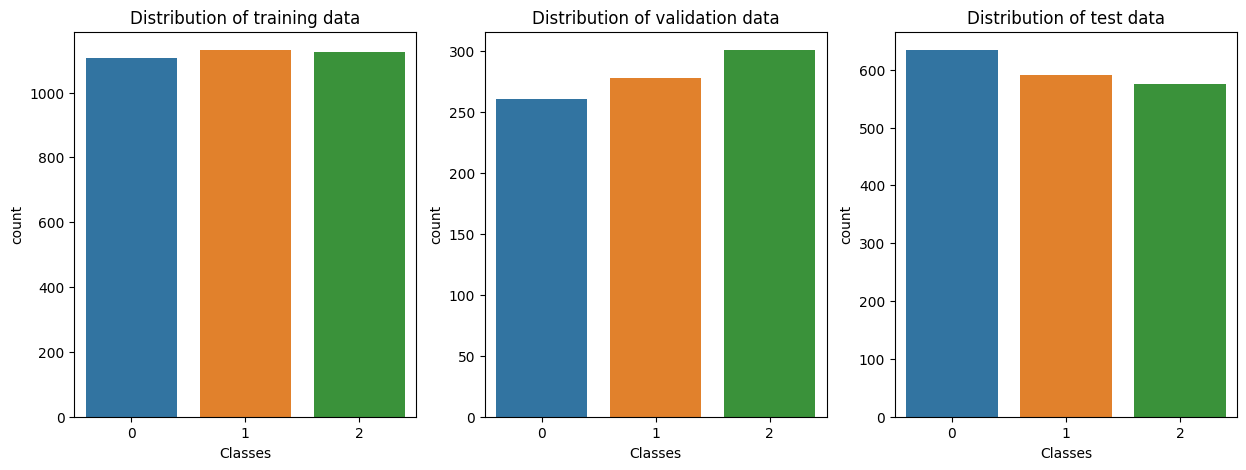

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5)) 

sns.countplot(x=np.argmax(Y_train, axis=1).ravel(), ax=axs[0]);
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')

sns.countplot(x=np.argmax(Y_val, axis=1).ravel(), ax=axs[1]);
axs[1].set_title('Distribution of validation data')
axs[1].set_xlabel('Classes')

sns.countplot(x=np.argmax(Y_test, axis=1).ravel(), ax=axs[2]);
axs[2].set_title('Distribution of test data')
axs[2].set_xlabel('Classes')
plt.show()


Определяем функции создания моделей

In [ ]:
def create_rnn(dropout, normalization):
    model = Sequential()
    model.add(Embedding(TOP_K + 1, 16))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3, input_shape=()))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    if normalization:
        model.add(BatchNormalization())
    model.add(Dense(128, activation="relu"))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(3, activation="sigmoid", name="predictions"))
    return model

In [ ]:
def build_classifier_model():
  text_input = Input(shape=(1,), dtype=tf.string, name='text')
  inputs_1d = tf.reshape(text_input, [-1])
  preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(inputs_1d)
  encoder = hub.KerasLayer(bert_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = Dropout(0.3)(net)
  net = Dense(3, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
def create_bidirectional(dropout, normalization):
    model = Sequential()
    model.add(Embedding(TOP_K + 1, 16))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Bidirectional(tf.keras.layers.LSTM(64)))
    if normalization:
        model.add(BatchNormalization())
    model.add(Dense(64, activation="relu"))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(3, activation="sigmoid", name="predictions"))
    return model

**Загрузить предобученную нейросеть с возможностью редактировать слои, дообучить для своих данных. (провести сравнение качества работы сети из "коробки" с дообученной)**


---



In [ ]:
bert = build_classifier_model()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
bert.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate=0.00001),
              metrics = ['categorical_accuracy'])

In [ ]:
bert_history = bert.fit(x=X_train_raw, y=Y_train,
              validation_data=(X_val_raw, Y_val),
              epochs=5)

Epoch 1/5
105/105 [==============================] - 151s 1s/step - loss: 1.0872 - categorical_accuracy: 0.4021 - val_loss: 1.0384 - val_categorical_accuracy: 0.4488
Epoch 2/5
105/105 [==============================] - 111s 1s/step - loss: 1.0129 - categorical_accuracy: 0.4759 - val_loss: 1.0024 - val_categorical_accuracy: 0.4952
Epoch 3/5
105/105 [==============================] - 120s 1s/step - loss: 0.9673 - categorical_accuracy: 0.5161 - val_loss: 0.9872 - val_categorical_accuracy: 0.4976
Epoch 4/5
105/105 [==============================] - 112s 1s/step - loss: 0.9273 - categorical_accuracy: 0.5518 - val_loss: 0.9756 - val_categorical_accuracy: 0.5119
Epoch 5/5
105/105 [==============================] - 110s 1s/step - loss: 0.8842 - categorical_accuracy: 0.5750 - val_loss: 0.9782 - val_categorical_accuracy: 0.5167


In [ ]:
rnn = create_rnn(dropout=0.5, normalization=False)

In [ ]:
rnn.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr=0.0001),
              metrics = ['categorical_accuracy'])

In [ ]:
rnn_history = rnn.fit(x=X_train, y=Y_train,
              validation_data=(X_val, Y_val),
              epochs=20, 
              batch_size=128)

Epoch 1/20
27/27 [==============================] - 12s 180ms/step - loss: 1.1001 - categorical_accuracy: 0.3318 - val_loss: 1.0992 - val_categorical_accuracy: 0.3119
Epoch 2/20
27/27 [==============================] - 2s 71ms/step - loss: 1.0992 - categorical_accuracy: 0.3342 - val_loss: 1.0986 - val_categorical_accuracy: 0.3310
Epoch 3/20
27/27 [==============================] - 1s 48ms/step - loss: 1.0995 - categorical_accuracy: 0.3375 - val_loss: 1.0990 - val_categorical_accuracy: 0.3310
Epoch 4/20
27/27 [==============================] - 1s 35ms/step - loss: 1.0990 - categorical_accuracy: 0.3315 - val_loss: 1.0986 - val_categorical_accuracy: 0.3143
Epoch 5/20
27/27 [==============================] - 1s 38ms/step - loss: 1.0986 - categorical_accuracy: 0.3417 - val_loss: 1.0978 - val_categorical_accuracy: 0.3619
Epoch 6/20
27/27 [==============================] - 1s 19ms/step - loss: 1.0988 - categorical_accuracy: 0.3256 - val_loss: 1.0978 - val_categorical_accuracy: 0.3619
Epoch 7/

In [ ]:
bert_scores = bert.evaluate(X_test_raw, Y_test, verbose=1)
rnn_scores = rnn.evaluate(X_test, Y_test, verbose=1)
print(f'Test loss:\nBERT: {round(bert_scores[0], 4)}\tRNN: {round(rnn_scores[0], 4)}')
print(f'Test accuracy:\nBERT: {round(bert_scores[1], 4)}\tRNN: {round(rnn_scores[1], 4)}')

bert_pred = bert.predict(X_test_raw)
rnn_pred = rnn.predict(X_test)

57/57 [==============================] - 0s 4ms/step - loss: 0.7197 - categorical_accuracy: 0.6817
Test loss:
BERT: 0.9711	RNN: 0.7197
Test accuracy:
BERT: 0.51	RNN: 0.6817
57/57 [==============================] - 0s 3ms/step


In [ ]:
compare_models = {'bert': [bert_history, bert_pred], 'rnn': [rnn_history, rnn_pred]}

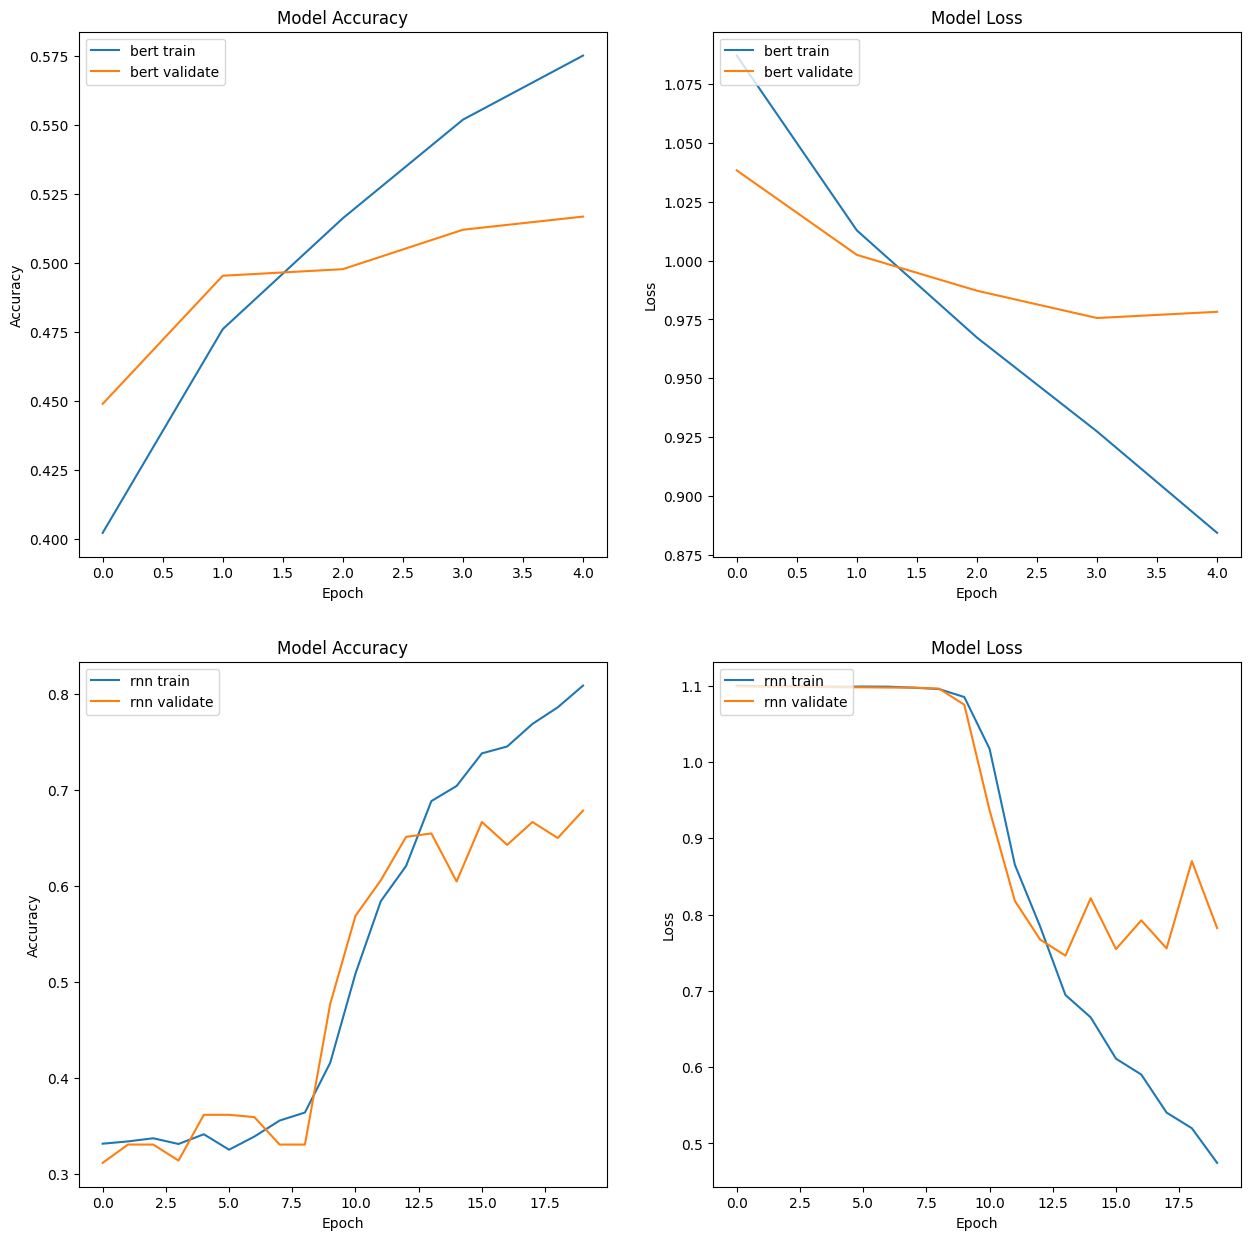

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,15)) 
for i, model in enumerate(compare_models.items()):
    model, history = model[0], model[1][0]
    axs[i, 0].plot(history.history['categorical_accuracy']) 
    axs[i, 0].plot(history.history['val_categorical_accuracy']) 
    axs[i, 0].set_title('Model Accuracy')
    axs[i, 0].set_ylabel('Accuracy') 
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].legend([f'{model} train', f'{model} validate'], loc='upper left')
    axs[i, 1].plot(history.history['loss']) 
    axs[i, 1].plot(history.history['val_loss']) 
    axs[i, 1].set_title('Model Loss')
    axs[i, 1].set_ylabel('Loss') 
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].legend([f'{model} train', f'{model} validate'], loc='upper left')
plt.show();

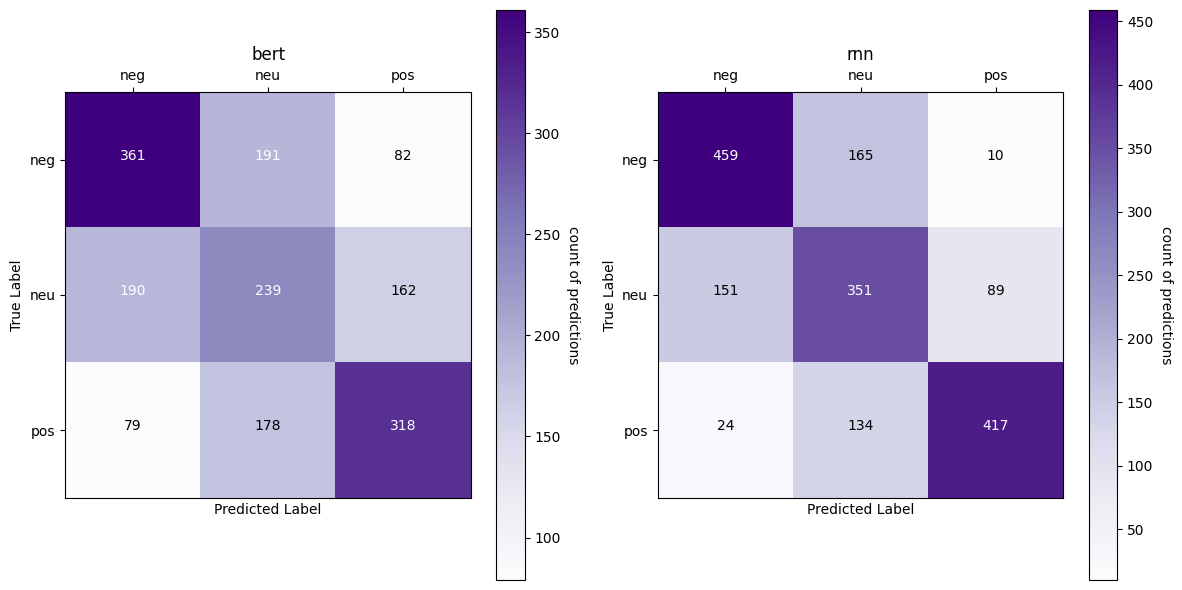

In [ ]:
labels = ['neg', 'neu', 'pos']
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i, item in enumerate(compare_models.items()):
    model, pred = item[0], item[1][1]
    Y_pred_classes = np.argmax(pred, axis=1) 
    Y_true = np.argmax(Y_test, axis=1)
    errors = (Y_pred_classes - Y_true != 0)

    cm = confusion_matrix(Y_true, Y_pred_classes) 
    thresh = cm.max() / 2.

    im = ax[i].imshow(cm, cmap='Purples')
    cbar = ax[i].figure.colorbar(im, ax=ax[i])
    cbar.ax.set_ylabel("count of predictions", rotation=-90, va="bottom")
    ax[i].set_title(model)
    ax[i].tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax[i].set_xticks(np.arange(cm.shape[1]))
    ax[i].set_yticks(np.arange(cm.shape[0]))
    ax[i].set_xticklabels(labels)
    ax[i].set_yticklabels(labels)    
    ax[i].set_xlabel('Predicted Label') 
    ax[i].set_ylabel('True Label')

    texts = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = im.axes.text(j, i, format(cm[i, j], "d"), horizontalalignment="center",
                                        color="white" if cm[i, j] > thresh else "black")
            texts.append(text)

fig.tight_layout()
plt.show()

Получилось, что конкретно для этой задачи лучше сработала созданная с нуля рекуррентная сеть, хотя график истории и для потерь, и для точности у Берта был более гладкий.

По heatmap-у видно, что bert хуже всего справился с нейтральными отзывами, чаще определяя их как положительные, рекуррентной сети нейтральные отзывы тоже дались хуже, чем положительные или отрицательные, но при этом среди нейтральных true neutral больше, чем fake positive и fake negative.

**Сравнить методы визуализации векторов**

---



In [ ]:
idx = np.random.choice(np.arange(len(vec_X)), 200, replace=False)
x_sample = vec_X[idx]
y_sample = Y_int[idx]

In [ ]:
n_neighbors = 30

In [ ]:
def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for label in y_sample:
        ax.scatter(
            *X[y_sample == label].T,
            marker=f"${label}$",
            s=60,
            color=plt.cm.Dark2(label),
            alpha=0.425,
            zorder=2,
        )
    ax.set_title(title)
    ax.axis("off")

In [ ]:
embeddings = {
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embeedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [ ]:
projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = x_sample.copy()
        data.flat[:: x_sample.shape[1] + 1] = data.flat[:: x_sample.shape[1] + 1] + 0.01  # Make X invertible
    else:
        data = x_sample

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y_sample)
    timing[name] = time() - start_time

Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embeedding...
Computing NCA embedding...


0 - negative\
1- neutral\
2 - positive

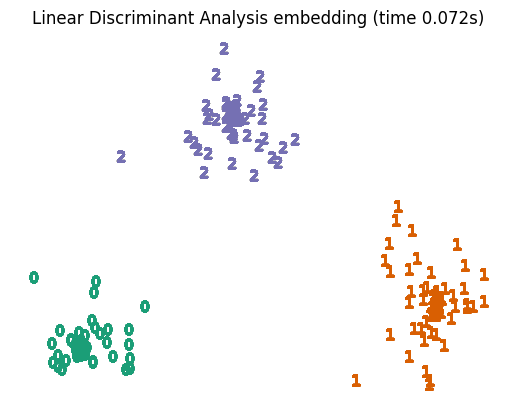

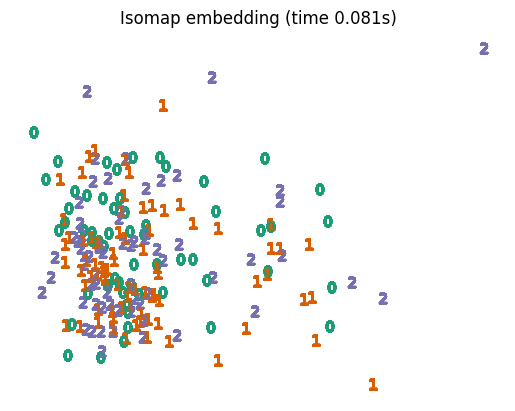

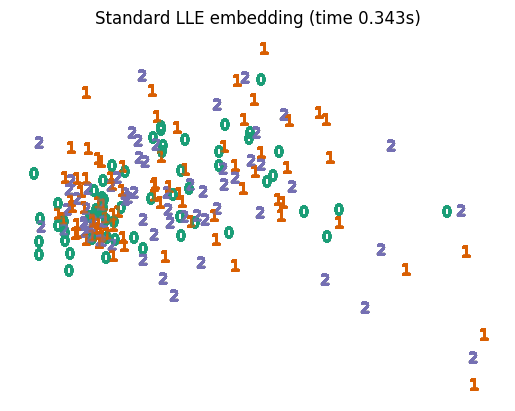

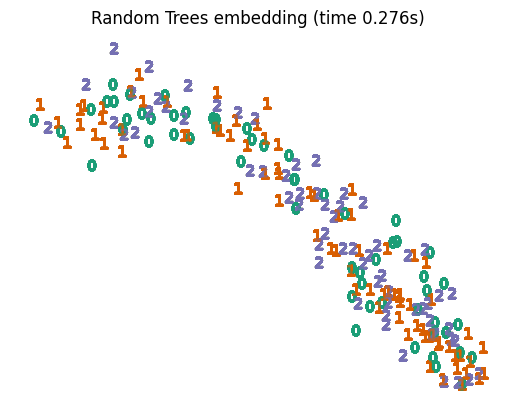

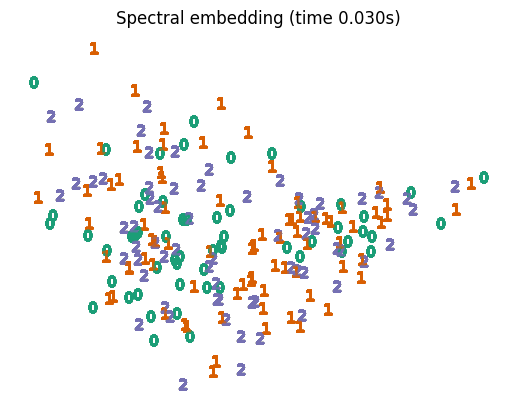

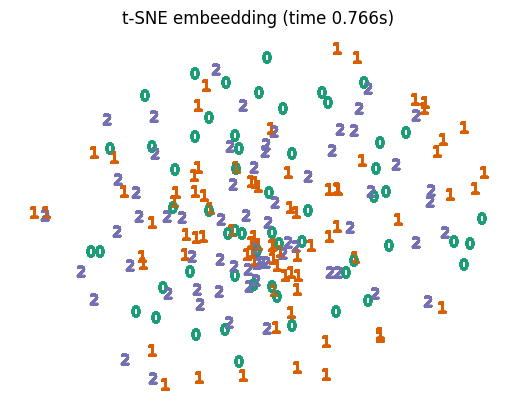

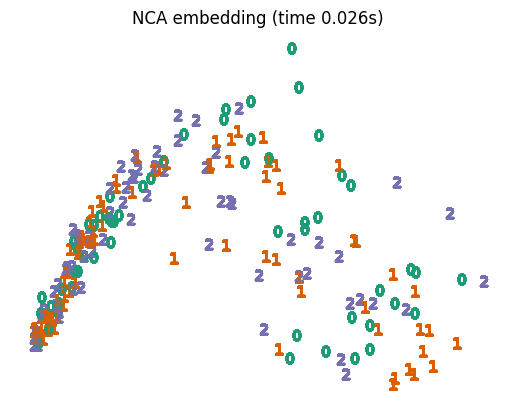

In [ ]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()

Как видно по графикам, ближе всего к правде все-таки Linear Discriminant Analysis, там примеры с одним лайблом находятся и в одном кластере

**Сравнить модели с разными параметрами**

---



In [ ]:
standard_lr = 0.0001
small_lr = standard_lr / 2
big_lr = standard_lr * 2

Задаем информацию обо всех нужных нам моделях

In [ ]:
rnns_info = [
    {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 80,
        'dropout': 0.5,
        'normalization': False,
    },
    {
        'type': 'conv',
        'optimizer': 'RMSprop',
        'learning_rate': standard_lr,
        'epochs': 80,
        'dropout': 0.5,
        'normalization': False,
    },
    {
        'type': 'conv',
        'optimizer': 'SGD',
        'learning_rate': 0.01,
        'epochs': 80,
        'dropout': 0.5,
        'normalization': False,
    },
    {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 80,
        'dropout': 0,
        'normalization': False,
    },
      {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 80,
        'dropout': 0,
        'normalization': True,
    },
    {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 80,
        'dropout': 0,
        'normalization': 'sklearn',   
    },
    {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 80,
        'dropout': 0.5,
        'normalization': True,
    },
    {
        'type': 'bidir',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 30,
        'dropout': 0.5,
        'normalization': False,
    },
    {
        'type': 'bidir',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 30,
        'dropout': 0,
        'normalization': True,
    },
    {
        'type': 'bidir',
        'optimizer': 'Adam',
        'learning_rate': standard_lr,
        'epochs': 30,
        'dropout': 0.5,
        'normalization': True,   
    },
    {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': small_lr,
        'epochs': 120,
        'dropout': 0.5,
        'normalization': False,
    },
    {
        'type': 'conv',
        'optimizer': 'Adam',
        'learning_rate': big_lr,
        'epochs': 35,
        'dropout': 0.5,
        'normalization': False,
    },
]

Преобразуем из json-формата в датафрейм и добавляем столбцы под значения потерь и точности на тестовых данных

In [ ]:
rnns_info = pd.DataFrame(rnns_info)

In [ ]:
rnns_info['loss'] = np.nan
rnns_info['accuracy'] = np.nan

Смотрим на полученный датафрейм

In [ ]:
rnns_info

,type,optimizer,learning_rate,epochs,dropout,normalization,loss,accuracy
0,conv,Adam,0.00010,80,0.5,False,NaN,NaN
1,conv,RMSprop,0.00010,80,0.5,False,NaN,NaN
2,conv,SGD,0.01000,80,0.5,False,NaN,NaN
3,conv,Adam,0.00010,80,0.0,False,NaN,NaN
4,conv,Adam,0.00010,80,0.0,True,NaN,NaN
5,conv,Adam,0.00010,80,0.0,sklearn,NaN,NaN
6,conv,Adam,0.00010,80,0.5,True,NaN,NaN
7,bidir,Adam,0.00010,30,0.5,False,NaN,NaN
8,bidir,Adam,0.00010,30,0.0,True,NaN,NaN
9,bidir,Adam,0.00010,30,0.5,True,NaN,NaN


Тренируем все модели

In [ ]:
history = []

In [ ]:
for model_info in rnns_info.itertuples():
    normal = model_info.normalization is not np.nan and model_info.normalization != 'sklearn'
    if model_info.type == 'conv':
        model = create_rnn(
            dropout = model_info.dropout, 
            normalization = normal)
    else:
        model = create_bidirectional(
            dropout = model_info.dropout, 
            normalization = normal)
    loss = 'categorical_crossentropy'
    metrics = ['categorical_accuracy']
    lr = model_info.learning_rate
    if model_info.optimizer == 'RMSprop':
        model.compile(loss = loss, optimizer = RMSprop(learning_rate = lr), metrics = metrics)
    elif model_info.optimizer == 'Adam':
        model.compile(loss = loss, optimizer = Adam(learning_rate = lr), metrics = metrics)
    else:
        model.compile(loss = loss, optimizer = SGD(learning_rate = lr), metrics = metrics)
    if model_info.normalization != 'sklearn':
        x_train, x_val, x_test = X_train, X_val, X_test
    else:
        x_train, x_val, x_test = X_train_norm, X_val_norm, X_test_norm
    model_history = model.fit(
        x=x_train, y=Y_train,
        validation_data = (x_val, Y_val),
        batch_size = 128,
        epochs=model_info.epochs)
    scores = model.evaluate(x_test, Y_test, verbose=1)
    rnns_info['loss'][model_info.Index] = scores[0]
    rnns_info['accuracy'][model_info.Index] = scores[1]
    history.append(model_history)
    model = None

Epoch 1/80
27/27 [==============================] - 7s 138ms/step - loss: 1.1183 - categorical_accuracy: 0.3277 - val_loss: 1.0982 - val_categorical_accuracy: 0.3321
Epoch 2/80
27/27 [==============================] - 2s 75ms/step - loss: 1.1117 - categorical_accuracy: 0.3307 - val_loss: 1.0982 - val_categorical_accuracy: 0.3345
Epoch 3/80
27/27 [==============================] - 2s 58ms/step - loss: 1.1126 - categorical_accuracy: 0.3366 - val_loss: 1.0982 - val_categorical_accuracy: 0.3381
Epoch 4/80
27/27 [==============================] - 1s 35ms/step - loss: 1.1070 - categorical_accuracy: 0.3414 - val_loss: 1.0982 - val_categorical_accuracy: 0.3393
Epoch 5/80
27/27 [==============================] - 1s 37ms/step - loss: 1.1060 - categorical_accuracy: 0.3369 - val_loss: 1.0983 - val_categorical_accuracy: 0.3250
Epoch 6/80
27/27 [==============================] - 1s 30ms/step - loss: 1.1054 - categorical_accuracy: 0.3438 - val_loss: 1.0983 - val_categorical_accuracy: 0.3214
Epoch 7/8

<ipython-input-69-e9a56f73ecf1>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnns_info['loss'][model_info.Index] = scores[0]
<ipython-input-69-e9a56f73ecf1>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnns_info['accuracy'][model_info.Index] = scores[1]


Epoch 1/80
27/27 [==============================] - 6s 137ms/step - loss: 1.1080 - categorical_accuracy: 0.3506 - val_loss: 1.0989 - val_categorical_accuracy: 0.3226
Epoch 2/80
27/27 [==============================] - 2s 92ms/step - loss: 1.1113 - categorical_accuracy: 0.3429 - val_loss: 1.0988 - val_categorical_accuracy: 0.3119
Epoch 3/80
27/27 [==============================] - 2s 63ms/step - loss: 1.1011 - categorical_accuracy: 0.3551 - val_loss: 1.0988 - val_categorical_accuracy: 0.3202
Epoch 4/80
27/27 [==============================] - 1s 37ms/step - loss: 1.1110 - categorical_accuracy: 0.3488 - val_loss: 1.0989 - val_categorical_accuracy: 0.3226
Epoch 5/80
27/27 [==============================] - 1s 31ms/step - loss: 1.1066 - categorical_accuracy: 0.3458 - val_loss: 1.0987 - val_categorical_accuracy: 0.3155
Epoch 6/80
27/27 [==============================] - 1s 44ms/step - loss: 1.1050 - categorical_accuracy: 0.3461 - val_loss: 1.0987 - val_categorical_accuracy: 0.3179
Epoch 7/8

**Сравнить различные методы оптимизации**


---


In [ ]:
rnns_info[['optimizer', 'loss', 'accuracy']][:3]

,optimizer,loss,accuracy
0,Adam,0.766592,0.676111
1,RMSprop,0.896025,0.587778
2,SGD,0.777558,0.628889


Лучше всего на тестовых данных показал себя Adam (и по потерям, и по точности)

In [ ]:
cols = rnns_info.optimizer[:3].to_list()

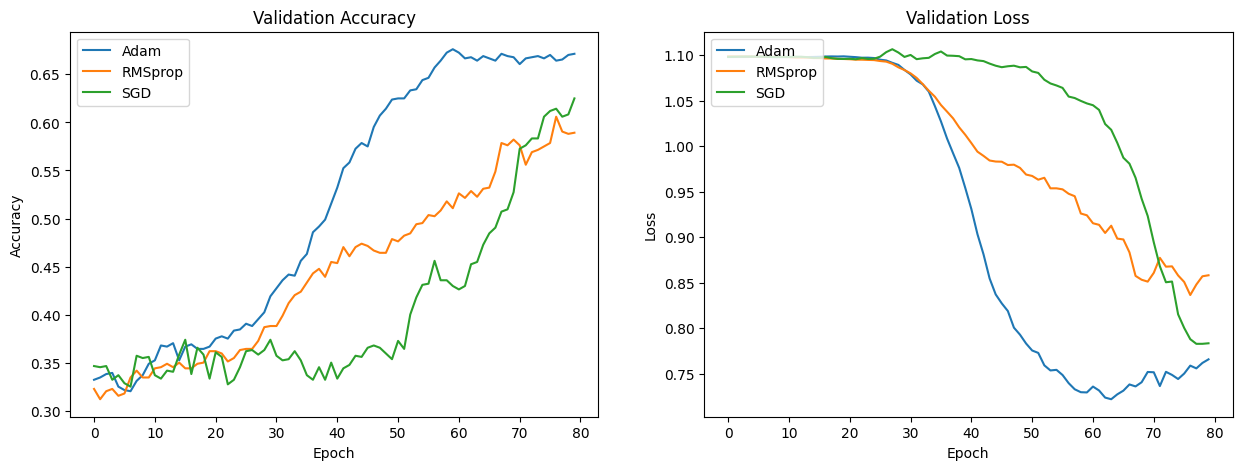

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
for i in range(3):
    axs[0].plot(history[i].history['val_categorical_accuracy']) 
    axs[0].set_title('Validation Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')

    axs[1].plot(history[i].history['val_loss']) 
    axs[1].set_title('Validation Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
axs[0].legend(cols, loc='upper left')
axs[1].legend(cols, loc='upper left')
plt.show();

По графикам истории тоже видно, что кривые Adam-а наиболее гладкие. Accuracy принимает в конце наибольшее значение из всех 3 методов, а loss - наименьшее

**Сравнить различные способы повышения обобщающей способности (различные пакетные нормализации, "заморозку" dropout и провести серию экспериментов для нейросетей различных размеров по числу обучаемых параметров)**


---



Для не-bidirectional модели с conv-1d слоями

In [ ]:
cols = ['no dropout & normalization', 'dropout', 'normalization', 'sklearn normalizatoin', 'dropout & normalization']

In [ ]:
rnns_info[['dropout', 'normalization', 'loss', 'accuracy']].iloc[[3, 0, 4, 5, 6]].reset_index(drop=True)

,dropout,normalization,loss,accuracy
0,0.0,False,1.631437,0.451111
1,0.5,False,0.766592,0.676111
2,0.0,True,1.638010,0.461111
3,0.0,sklearn,1.098892,0.328333
4,0.5,True,0.956995,0.627778


Видно, что с dropout-ом все работает точно лучше, чем без него. 

Нормализация же не особо улучшает результаты модели, и, как видно по последней модели, может даже ухудшать (относительно модели с дропаутом и без нормализации)

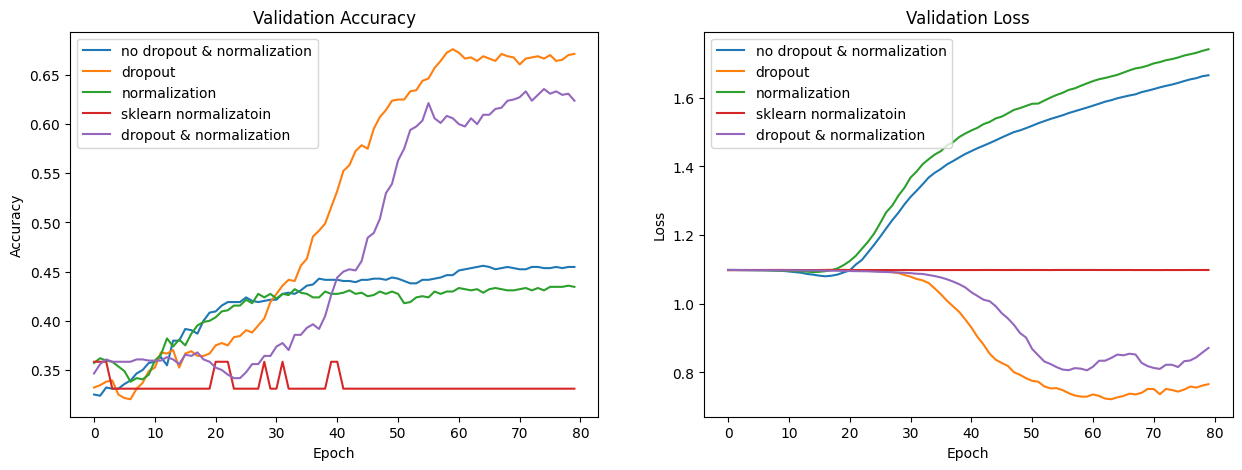

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
for i in [3, 0, 4, 5, 6]:
    axs[0].plot(history[i].history['val_categorical_accuracy']) 
    axs[0].set_title('Validation Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')

    axs[1].plot(history[i].history['val_loss']) 
    axs[1].set_title('Validation Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
axs[0].legend(cols, loc='upper left')
axs[1].legend(cols, loc='upper left')
plt.show();

Тут тоже видно, что лучше всего работает модель с дропаутом и без нормализации
Чуть хуже - с дропаутом и нормализацией

Модели без дропаута и нормализацией и с нормализацией, но без дропаута улучшают точность, но увеличивают потери

Модель с нормализацией sklearn вообще не обучается

In [ ]:
cols = [cols[1], cols[2], cols[4]]

Теперь посмотрим для bidirectional lstm моделей

In [ ]:
rnns_info[['dropout', 'normalization', 'loss', 'accuracy']][7:10].reset_index(drop=True)

,dropout,normalization,loss,accuracy
0,0.5,False,0.767336,0.648333
1,0.0,True,7.741046,0.357778
2,0.5,True,0.807910,0.650556


Тут все намного грустнее, чем в случае conv1d, но опять модели с дропаутом работают лучше, чем без него

При этом нормализация с дропаутом тут имеет чуть лучшую точность, но при этом намного большие потери

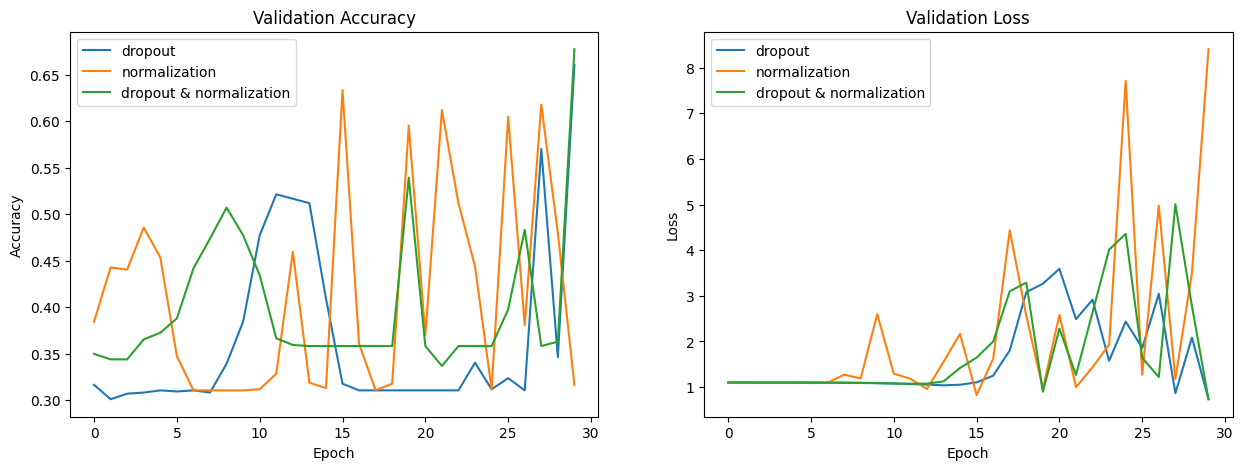

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
for i in range(7, 10):
    axs[0].plot(history[i].history['val_categorical_accuracy']) 
    axs[0].set_title('Validation Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')

    axs[1].plot(history[i].history['val_loss']) 
    axs[1].set_title('Validation Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
axs[0].legend(cols, loc='upper left')
axs[1].legend(cols, loc='upper left')
plt.show();

Нда...

**Провести эксперимент с нейросетями для случаев использования различных параметров модели (например, шаг обучения)**

---




In [ ]:
cols = ['lr = 5e-5', 'lr = 1e-4', 'lr = 2e-4']

In [ ]:
rnns_info[['learning_rate', 'loss', 'accuracy']].iloc[[10, 0, 11]].reset_index(drop=True)

,learning_rate,loss,accuracy
0,0.00005,0.831319,0.625556
1,0.00010,0.766592,0.676111
2,0.00020,0.963260,0.581667


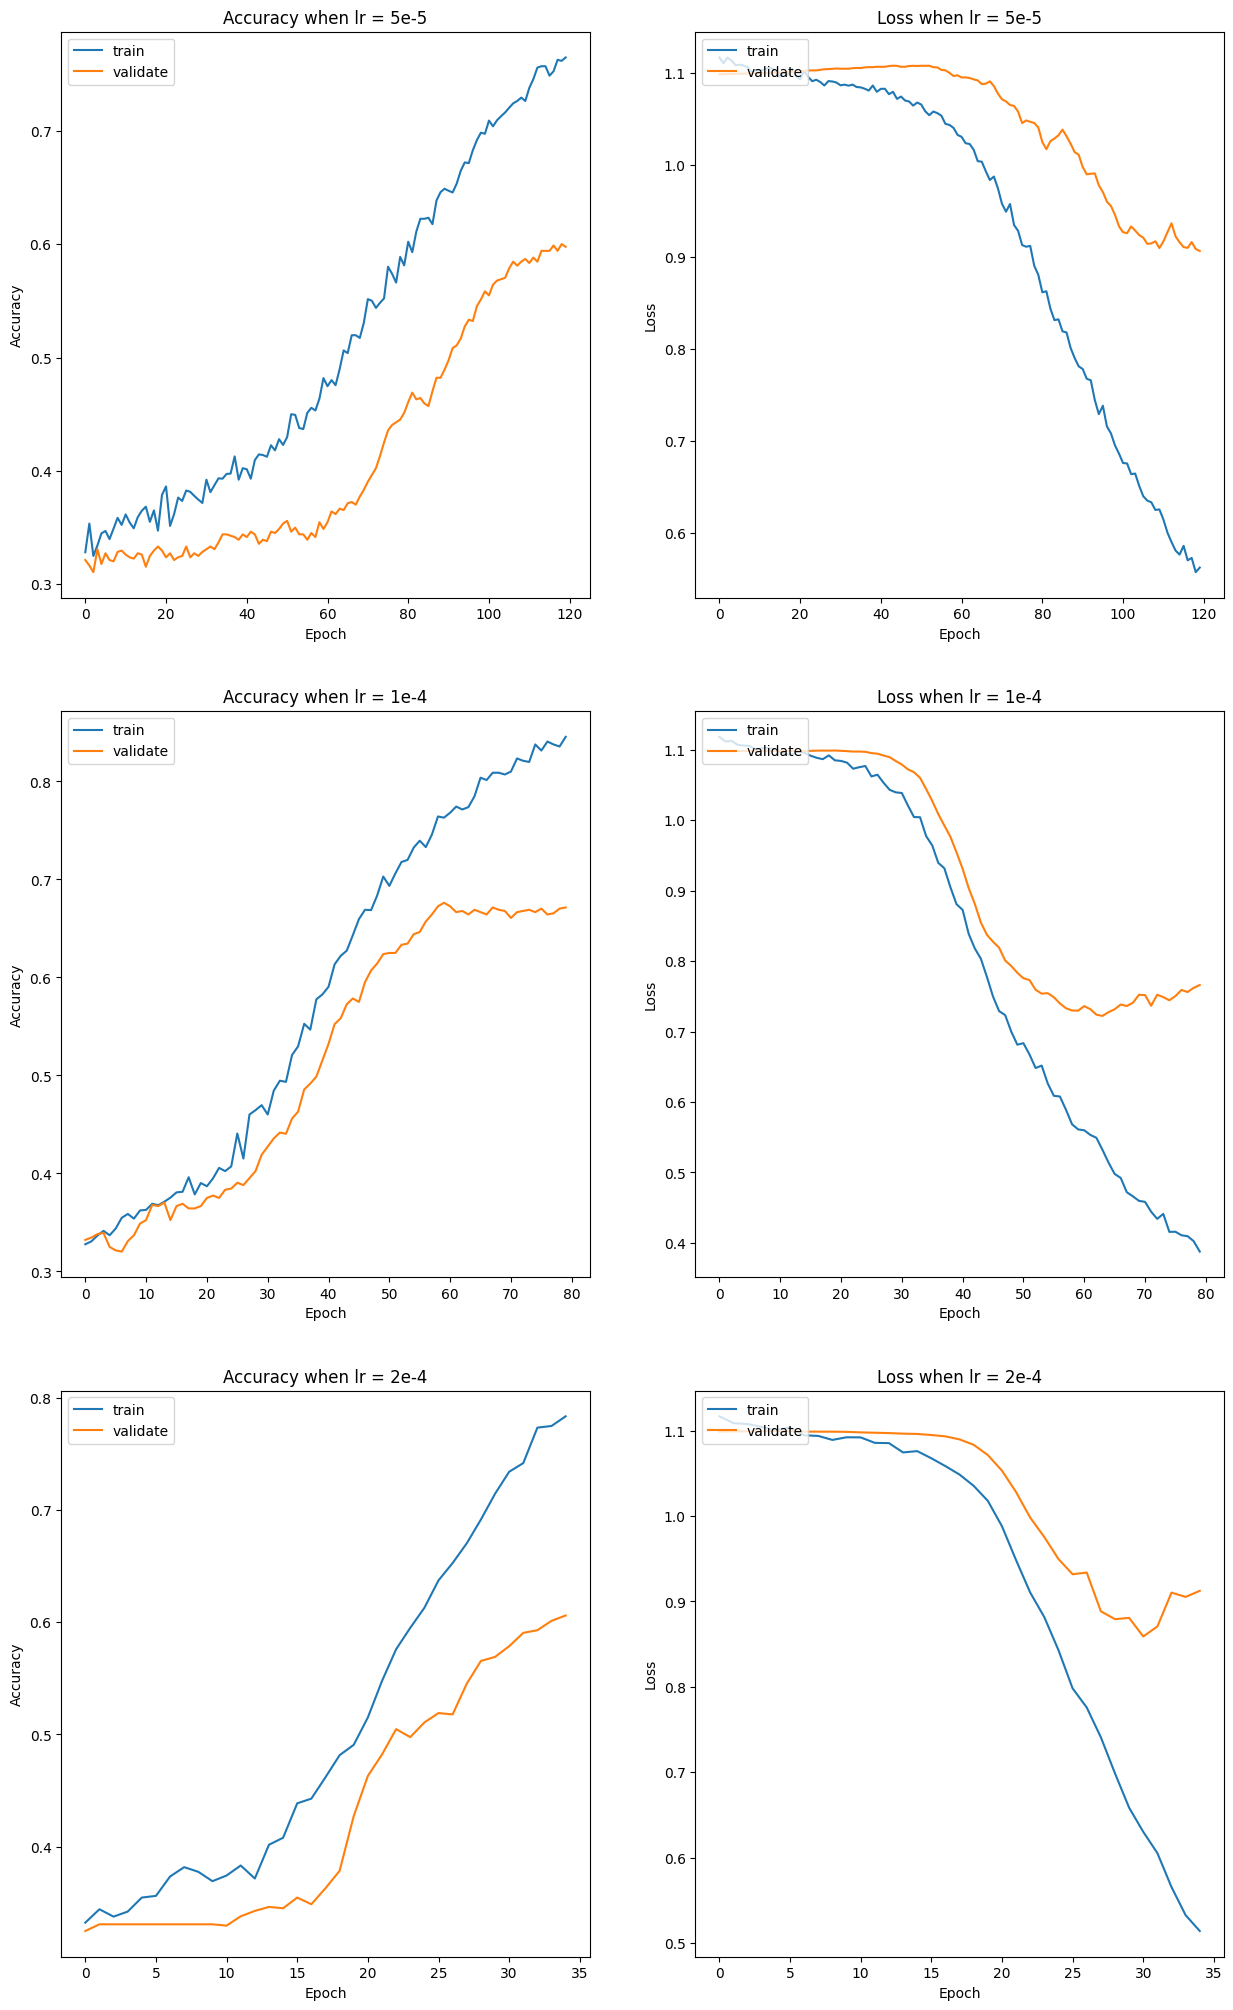

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(15,25)) 
for id, i in enumerate([10, 0, 11]):
    axs[id, 0].plot(history[i].history['categorical_accuracy']) 
    axs[id, 0].plot(history[i].history['val_categorical_accuracy']) 
    axs[id, 0].set_title(f'Accuracy when {cols[id]}')
    axs[id, 0].set_ylabel('Accuracy') 
    axs[id, 0].set_xlabel('Epoch')
    axs[id, 0].legend(['train', 'validate'], loc='upper left')

    axs[id, 1].plot(history[i].history['loss'])
    axs[id, 1].plot(history[i].history['val_loss']) 
    axs[id, 1].set_title(f'Loss when {cols[id]}')
    axs[id, 1].set_ylabel('Loss') 
    axs[id, 1].set_xlabel('Epoch')
    axs[id, 1].legend(['train', 'validate'], loc='upper left')
plt.show();

Андерфиттинг есть при любом lr, но лучше всего для этих данных lr = 1e-4

Лучше всех модель с оптимизацией Adam, с дропаутом 0.5 и без нормализации. Воссоздаем и смотрим, сколько параметров

In [ ]:
model = create_rnn(
    dropout = 0.5, 
    normalization = False)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 16)          32016     
                                                                 
 dropout_29 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d_30 (Conv1D)          (None, None, 128)         14464     
                                                                 
 conv1d_31 (Conv1D)          (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_15 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                     

Т.е. всего параметров 178195